## Tria COVID-19 Datathlon
### Seyyid Emre Sofuoglu
#### 04/19/2020

# ___COVID-19 Analysis and Simulations___

## Background and Motivation

For the last 4 months the pandemic has been roaming the earth, putting us to our places (literally). The whole world is affected by it and by far, we have no solutions but running and hiding. Still, a disaster is exactly defined like this and this is an experience to learn from.

So far, there have been many analyses on the spread and biology on COVID-19 by people who are the best of their fields. By no means, I aim to produce something more valuable than those studies but I aim to explore my own country, Turkiye, for which there are not many studies and not many useful data around. I will utilize the existing data for other countries in the world and several models, e.g. SIR, for this. 

I will use publicly available COVID-19 Dataset provided kindly by [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide). In this dataset, we have daily cases and number of deaths. I will try to make a model that will be applicable on different countries with varying circumstances.

## Data
The first data we have is the worldwide data for many countries. Let's have a look.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.integrate import odeint
from scipy.optimize import curve_fit
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_style('whitegrid')

In [2]:
world_data = pd.read_csv('COVID-19-geographic-disbtribution-worldwide-2020-04-18.csv')
world_data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,4/18/2020,18,4,2020,51,1,Afghanistan,AF,AFG,37172386.0
1,4/17/2020,17,4,2020,10,4,Afghanistan,AF,AFG,37172386.0
2,4/16/2020,16,4,2020,70,2,Afghanistan,AF,AFG,37172386.0
3,4/15/2020,15,4,2020,49,2,Afghanistan,AF,AFG,37172386.0
4,4/14/2020,14,4,2020,58,3,Afghanistan,AF,AFG,37172386.0


Now, let's have a look at the data on Turkiye.

In [3]:
def excel2datenum(matlab_dates):
    datenums = np.zeros_like(matlab_dates)
    for i in range(len(matlab_dates)):
        mystr = matlab_dates[i]
        res = mystr.rsplit(sep='/')
        res = res[0]+' '+res[1]+' '+res[2]
        res = datetime.strptime(res, '%m %d %Y')
        datenums[i] = datetime.toordinal(res)
    return datenums
world_data['dateRep'] = excel2datenum(world_data['dateRep'])

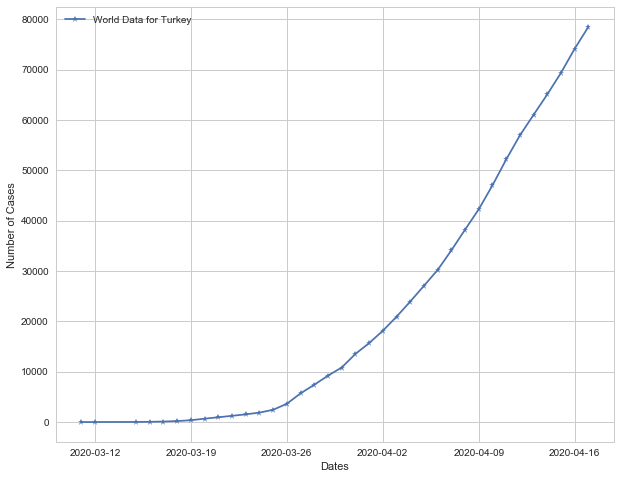

In [4]:
fig = plt.figure(figsize=(10,8))
mask = world_data['countriesAndTerritories']=='Turkey'
dates_fr_world = world_data['dateRep'][mask]
turkiye_from_world = world_data['cases'][mask]
plt.plot_date(dates_fr_world[::-1]-1, np.cumsum(turkiye_from_world[::-1]), '-*', label= 'World Data for Turkey')
plt.ylabel('Number of Cases')
plt.xlabel('Dates')
plt.legend();

It seems that a set of measures by government (Cancelling flights from Europe, Iran, South Kore etc., contact tracing, lots of tests, cancelling schools and universities at March 16th) had a big effect on slowing the pandemic at April 1st. Adding the influences of Italy, Iran and South Korea, these measures probably also helped more people decide on social isolation.

Now, let's see some comparisons between countries taking 100 total case counts as basis, or first day of the spread.

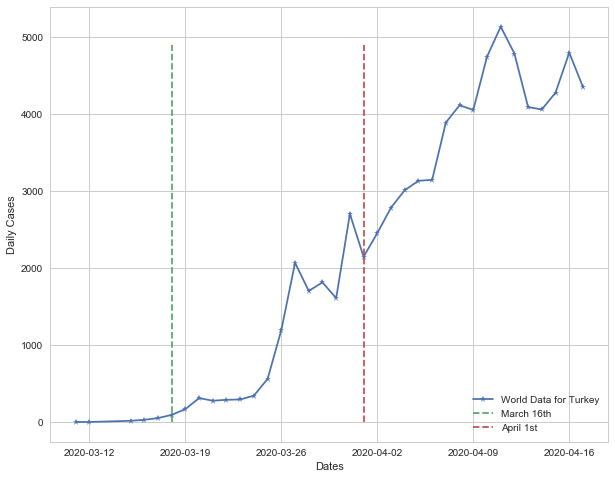

In [5]:
fig = plt.figure(figsize=(10,8))
mask = world_data['countriesAndTerritories']=='Turkey'
dates_fr_world = world_data['dateRep'][mask]
turkiye_from_world = world_data['cases'][mask]
plt.plot_date(dates_fr_world[::-1]-1, turkiye_from_world[::-1], '-*', label= 'World Data for Turkey')
plt.plot_date(np.ones(50)*737502,np.arange(0,5000,100), '--', label='March 16th')
plt.plot_date(np.ones(50)*737516,np.arange(0,5000,100), '--', label='April 1st')
plt.ylabel('Daily Cases')
plt.xlabel('Dates')
plt.legend();

In [6]:
def get_country(data, country, sep=1, ref = 0):
    mask = data['countriesAndTerritories']==country
    dates = data['dateRep'][mask]
    cases = data['cases'][mask]
    deaths = data['deaths'][mask]
    dates = dates.iloc[::-1]
    cases = cases.iloc[::-1]
    deaths = deaths.iloc[::-1]
    dist_from = np.array(np.abs(np.cumsum(cases)-sep))
    offset = max([dist_from.argmin(), np.nonzero(cases)[0][0]])
    if ref==0:
        first = 0
    else:
        first = dates.iloc[offset]
    dates = dates.iloc[offset:] - first + ref
    cases = cases.iloc[offset:]
    deaths = deaths.iloc[offset:]
    return dates, cases, deaths, first
def plot_country(world_data, country, sep=1, ref=0, pl_type='cases'):
    dates, cases, deaths, first = get_country(world_data, country, sep, ref)
    if pl_type=='cases':
        plt.plot_date(dates, cases, '-*', label= country)
    elif pl_type == 'deaths':
        plt.plot_date(dates, deaths, '-*', label= country)
    elif pl_type =='cumcases':
        plt.plot_date(dates, np.cumsum(cases), '-*', label= country)
    elif pl_type =='cumdeaths':
        plt.plot_date(dates, np.cumsum(deaths), '-*', label= country)
    return first

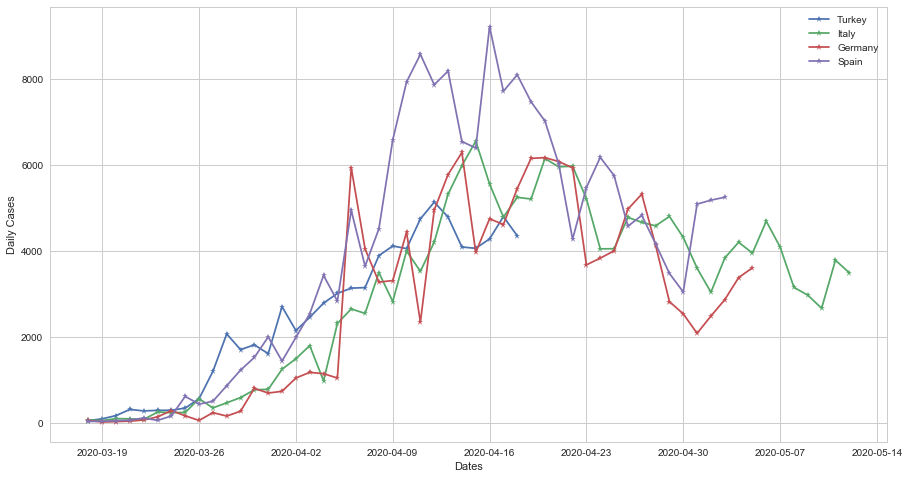

In [7]:
num_tot = 100
fig = plt.figure(figsize=(15,8))
offs = plot_country(world_data, 'Turkey', num_tot, dates_fr_world.iloc[-5])
# plot_country(world_data, 'South_Korea', num_tot, offs)
plot_country(world_data, 'Italy', num_tot, offs)
# plot_country(world_data, 'Iran', num_tot, offs)
plot_country(world_data, 'Germany', num_tot, offs)
plot_country(world_data, 'Spain', num_tot, offs)
plt.xlabel('Dates')
plt.ylabel('Daily Cases')
plt.legend();

We can see that there are similar trends of them all.Spain has a higher peak and Germany has some irregularities. But this is weird, we know that Germany has much less number of deaths than Spain or Italy, so what gives?

Let's see the daily deaths comparisons.

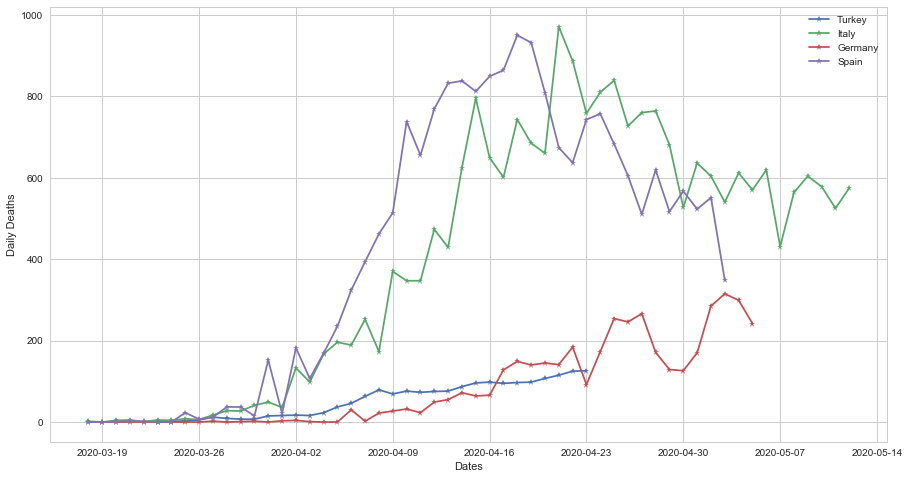

In [8]:
num_tot = 100
col = 'deaths'
fig = plt.figure(figsize=(15,8))
offs = plot_country(world_data, 'Turkey', num_tot, dates_fr_world.iloc[-10], col)
# plot_country(world_data, 'United_States_of_America', num_tot, offs, col)
plot_country(world_data, 'Italy', num_tot, offs, col)
# plot_country(world_data, 'Iran', num_tot, offs, col)
plot_country(world_data, 'Germany', num_tot, offs, col)
plot_country(world_data, 'Spain', num_tot, offs, col)
plt.xlabel('Dates')
plt.ylabel('Daily Deaths')
plt.legend();

We can see that Germany and Turkey now has much better picture compared to Italy and Spain. What might be the cause? What helped these countries achieve such low figures? 

Now let's analyze the data using models like SIR.

## Methodology

[SIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) is a compartmental model well known in epidemiology. Using this model, we will try to analyze various countries and try to see parameter variations among them.

In SIR models:
* **S** is very often used for "susceptible" to refer to people who can get a disease (some people may have some immunity).
* **I** refers to "infected", which means they have the disease; in many cases this is called **L** so that **I** can be used to refer to those that are infectious (i.e. can spread the disease).
* **R** refers to "recovered" or "removed".
* Another compartment we can use for our purposes is "deceased" **D**. The pandemic has a high death toll, so this is reasonable.

The model is governed by a set of differential equations which explain the transition between the compartments:
$$\frac{dS}{dt} = - \frac{\beta I S}{N},$$
$$\frac{dI}{dt} = \frac{\beta I S}{N}-\gamma I - \mu I,$$
$$\frac{dR}{dt} = \gamma I,$$
$$\frac{dD}{dt} = \mu I,$$
where $N$ corresponds to the total population. We know that with increaseing number of cases, hospitals run out of ICUs and death rate $\mu$ increases. But let's assume that it doesn't and continue with our analysis.

The model is simplistic. It does not consider changing public dynamics and government measures. It also assumes we have knowledge of all infected. But we will start by this to get some ideas, then improve. Let's define an update function.

In [9]:
# Update rules for SIRD model
def f(y, t, beta, gamma, mu):
        Si = y[0]
        Ii = y[1]
        Ri = y[2]
        Di = y[3]
        N = np.sum(y[0:4])
        # the model equations
        f0 = -beta*Si*Ii/N
        f1 = beta*Si*Ii/N - gamma*Ii - mu*Ii
        f2 = gamma*Ii
        f3 = mu*Ii
        return f0, f1, f2, f3

Now, the population of Turkey is about 85 millions, Germany is about 84 millions, Italy is about 60 million and Spain, 50. Hubei, in which a big majority of China's cases happened also is about 59 million. 

Let's fit the parameters on a country, e.g. Spain, and see how it looks. 

In [10]:
N = 50*10**6 # Population of Spain.
S0 = N-1 # Initial Susceptibles
I0 = 1 # Initial Cases
R0 = 0 # Initial Recoveries
D0 = 0 # Initial Deaths

y0 = [S0, I0, R0, D0]

def sird_odeint(t, beta, gamma, mu):
    # Solve DE's
    soln = odeint(f, y0, t, args=(beta, gamma, mu))
    S = soln[:, 0]
    I = soln[:, 1]
    R = soln[:, 2]
    D = soln[:, 3]
    return np.concatenate((I+R+D, D))

def fit_sird(data_fr, country, start = 0, end = -1, sep=0):
    dates, cases, deaths, first = get_country(data_fr, country, sep=sep)
    cases = np.array(np.cumsum(cases))
    deaths = np.array(np.cumsum(deaths))
    start = np.asscalar(np.array(start))
    end = np.asscalar(np.array(end))
    if end == -1:
        end = cases.size
    cases = np.split(cases, [start, end])[1]
    deaths = np.split(deaths, [start, end])[1]
    dates = np.split(np.array(dates), [start, end])[1]
    t = np.arange(len(cases))
    popt, pcov = curve_fit(sird_odeint, t, np.concatenate((cases, deaths)))
    est = sird_odeint(t, popt[0], popt[1], popt[2])
    est_cases, est_deaths = np.split(est, 2)
    return dates, cases, deaths, est_cases, est_deaths, popt
dates, cases, deaths, est_cases, est_deaths, popt = fit_sird(world_data, 'Spain')

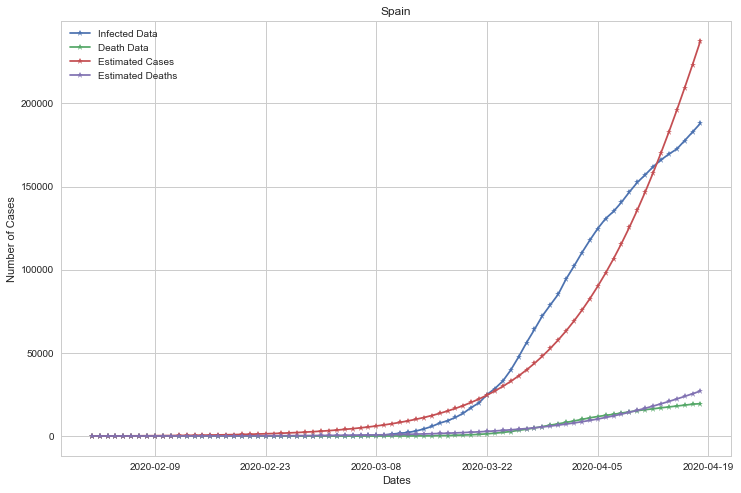

In [11]:
plt.figure(figsize=(12,8))
plt.plot_date(dates, cases, '-*', label= 'Infected Data')
plt.plot_date(dates, deaths, '-*', label= 'Death Data')
plt.plot_date(dates, est_cases, '-*', label='Estimated Cases')
plt.plot_date(dates, est_deaths, '-*', label='Estimated Deaths')
plt.legend()
plt.title('Spain')
plt.xlabel('Dates')
plt.ylabel('Number of Cases');

The fitted curve, while looking similar, is not very accurate for Spain. It is unable to model the curvature change. Cases change the curvature at some point, indicating the reaction of the people and government, so the model is undercomplex. Also, we know that the infected might not get symptoms for a while and do not get cured or die in a day, so there should be some delays in changes. 

Let's see how good is the model until the effects of the measures are visible, a.k.a. 14 days after measures took effect. Let's also check new countries such as Turkey and Germany as their populations have similar size and their situation also look similar right now.

In [12]:

spain = get_country(world_data, 'Spain', sep=0)
spain_dates = spain[0]
d = datetime.strptime('2020-03-28', '%Y-%m-%d').date()
last = np.where(np.array(spain_dates)==d.toordinal())
dates_s, cases_s, deaths_s, est_cases_s, est_deaths_s, popt = fit_sird(world_data, 'Spain', end=last)

N =  84000000 # Population of Turkey and Germany are similar.
S0 = N-1 # Initial Susceptibles
I0 = 1 # Initial Cases
R0 = 0 # Initial Recoveries
D0 = 0 # Initial Deaths

y0 = [S0, I0, R0, D0]

germany = get_country(world_data, 'Germany', sep=0)
germany_dates = germany[0]
d = datetime.strptime('2020-03-29', '%Y-%m-%d').date()
last = np.where(np.array(germany_dates)==d.toordinal())
dates_g, cases_g, deaths_g, est_cases_g, est_deaths_g, popt = fit_sird(world_data, 'Germany', end=last)
d = datetime.strptime('2020-04-01', '%Y-%m-%d').date()
last = np.where(np.array(dates_fr_world[::-1])==d.toordinal())
dates_t, cases_t, deaths_t, est_cases_t, est_deaths_t, popt = fit_sird(world_data, 'Turkey', end=last)

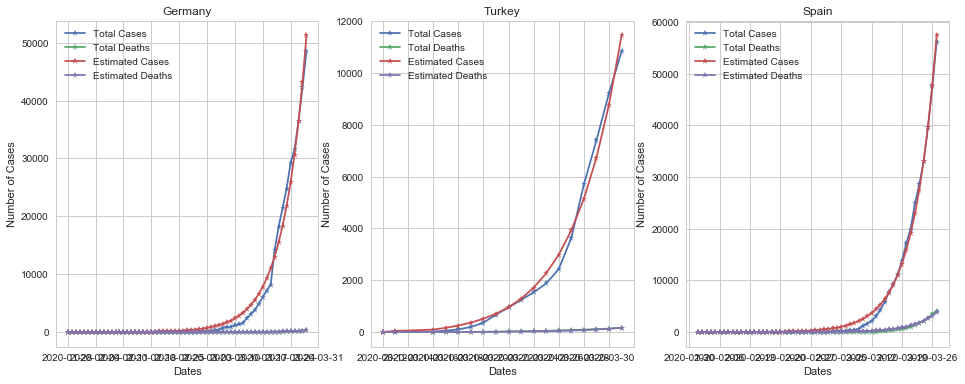

In [13]:
plt.subplots(1,3, figsize=(16,6))
plt.subplot(1,3,1)
plt.plot_date(dates_g, cases_g, '-*', label= 'Total Cases')
plt.plot_date(dates_g, deaths_g, '-*', label= 'Total Deaths')
plt.plot_date(dates_g, est_cases_g, '-*', label='Estimated Cases')
plt.plot_date(dates_g, est_deaths_g, '-*', label='Estimated Deaths')
plt.legend()
plt.title('Germany')
plt.xlabel('Dates')
plt.ylabel('Number of Cases')

plt.subplot(1,3,2)
plt.plot_date(dates_t, cases_t, '-*', label= 'Total Cases')
plt.plot_date(dates_t, deaths_t, '-*', label= 'Total Deaths')
plt.plot_date(dates_t, est_cases_t, '-*', label='Estimated Cases')
plt.plot_date(dates_t, est_deaths_t, '-*', label='Estimated Deaths')
plt.legend()
plt.title('Turkey')
plt.xlabel('Dates')
plt.ylabel('Number of Cases')

plt.subplot(1,3,3)
plt.plot_date(dates_s, cases_s, '-*', label= 'Total Cases')
plt.plot_date(dates_s, deaths_s, '-*', label= 'Total Deaths')
plt.plot_date(dates_s, est_cases_s, '-*', label='Estimated Cases')
plt.plot_date(dates_s, est_deaths_s, '-*', label='Estimated Deaths')
plt.legend()
plt.title('Spain')
plt.xlabel('Dates')
plt.ylabel('Number of Cases');

It seems the models fit the early stages very well, this brings the question: 

     How well will the model work if I assume there are two stages and fit my model accordingly?
     
Also, until now we only used visual interpretations but from now on, we will also see an estimation error $e$ defined by:

$ e = \frac{\|y-\hat{y}\|_2}{\|y\|_2} $,

where $y$ is the real number of cases as a time series vector, $\hat{y}$ is the vector, or array estimated by the model and $\|.\|_2$ is the $l_2$ norm, defined by: 

$\|x\|_2=\sqrt{\sum_{i=1}^n x_i^2}$.

In [14]:
def error_value(y, y_hat):
    x = y-y_hat
    e = np.sqrt(np.sum(x**2))/np.sqrt(np.sum(y**2))
    return e

Let's check the error values of the above. 

In [15]:
print('Error for Turkey is:',round(error_value(cases_t, est_cases_t),4))
print('Error for Germany is:',round(error_value(cases_g, est_cases_g),4))
print('Error for Spain is:',round(error_value(cases, est_cases),4))
print('Error for Spain when only cases until measures took effect is:',round(error_value(cases_s, est_cases_s),4))

Error for Turkey is: 0.0797
Error for Germany is: 0.0967
Error for Spain is: 0.2066
Error for Spain when only cases until measures took effect is: 0.0502


As expected, the model parameters get effected by the measures.

Now, let's turn back to the model with two stages. We will need prediction later on, so let's add the capability.

In [16]:
def fit_country(data_frame, country, measure_date, N, days_to_predict = 0):
    global y0
    S0 = N-1 # Initial Susceptibles
    I0 = 1 # Initial Cases
    R0 = 0 # Initial Recoveries
    D0 = 0 # Initial Deaths

    y0 = [S0, I0, R0, D0]

    data = get_country(data_frame, country, sep=0)
    dates = data[0]
    d = datetime.strptime(measure_date, '%Y-%m-%d').date()
    msr = np.where(np.array(dates) == d.toordinal())
    first_out = fit_sird(data_frame, country, end=msr)
    
    global second_out
    t = np.arange(len(first_out[0]))
    soln = odeint(f, y0, t, args=tuple(first_out[-1]))
    y0 = soln[-1,:]
    second_out = fit_sird(data_frame, country, start=msr[0]-1, end = len(dates)-days_to_predict)
    dates = np.concatenate((first_out[0], second_out[0]))
    cases = np.concatenate((first_out[1], second_out[1]))
    deaths = np.concatenate((first_out[2], second_out[2]))
    est_cases = np.concatenate((first_out[3], second_out[3]))
    est_deaths = np.concatenate((first_out[4], second_out[4]))
    popt = np.concatenate((first_out[5], second_out[5]))
    
    return dates, cases, deaths, est_cases, est_deaths, popt

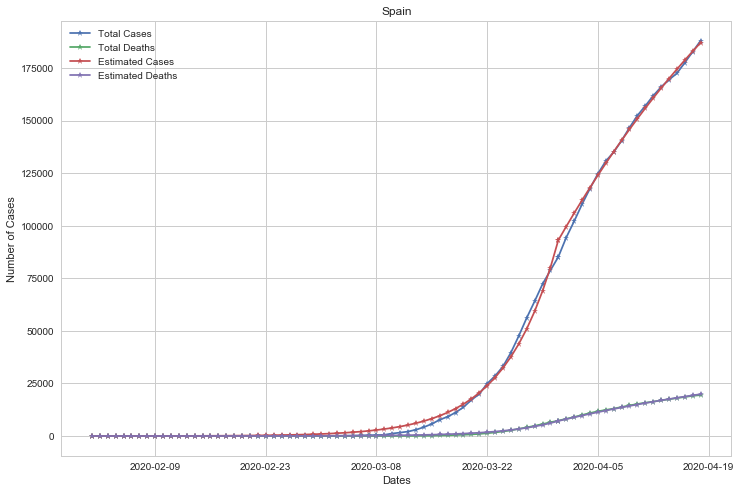

In [17]:
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(data_frame=world_data, 
                                                                country='Spain', measure_date='2020-04-01', N=84000000)
plt.figure(figsize=(12,8))
plt.plot_date(dates, cases, '-*', label= 'Total Cases')
plt.plot_date(dates, deaths, '-*', label= 'Total Deaths')
plt.plot_date(dates, est_cases, '-*', label='Estimated Cases')
plt.plot_date(dates, est_deaths, '-*', label='Estimated Deaths')
plt.legend()
plt.title('Spain')
plt.xlabel('Dates')
plt.ylabel('Number of Cases');

In [18]:
error_value(cases, est_cases)

0.028858783532019202

Now, this looks much better. Let us see the changes to the parameters.

In [19]:
print(popt)

[1.85322978 1.55940173 0.14219649 0.87074295 0.77823999 0.11806072]


We can see that spread rate dropped a lot. Weirdly enough, recovery rate fell down. This might be due to the lag in the deaths being much longer (about 5-10 days) than what the model assumes (1 day). Another thing is that we unfortunately do not have that much of a speedy recovery, these numbers are inflated to fit the curve as we didn't request the function to also fit the recovery data. So the R part of SIRD is not fitted to anything.

Let's leave these model issues to later and see how these parameters do in prediction.

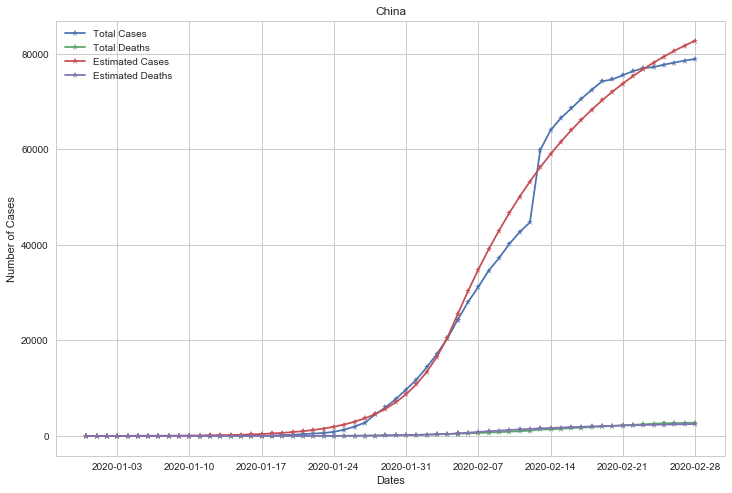

In [20]:
days_to_predict = 50
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='China', measure_date='2020-02-06', 
                                                                N=58500000, days_to_predict = days_to_predict)
plt.figure(figsize=(12,8))
plt.plot_date(dates, cases, '-*', label= 'Total Cases')
plt.plot_date(dates, deaths, '-*', label= 'Total Deaths')
plt.plot_date(dates, est_cases, '-*', label='Estimated Cases')
plt.plot_date(dates, est_deaths, '-*', label='Estimated Deaths')
plt.legend()
plt.title('China')
plt.xlabel('Dates')
plt.ylabel('Number of Cases');

In [21]:
error_value(cases, est_cases)

0.06656274271161639

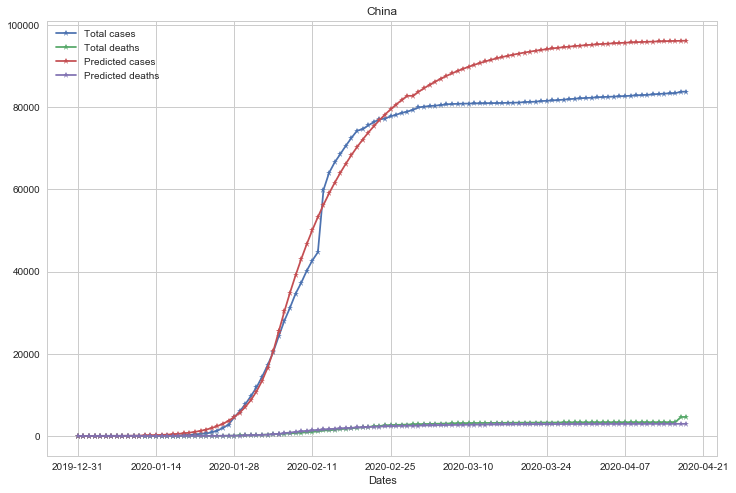

In [22]:
data = get_country(world_data, 'China')
plt.figure(figsize=(12,8))
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-(days_to_predict):]).astype(np.float)
time = np.concatenate((dates, t))
est = sird_odeint(t, popt[3], popt[4], popt[5])
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases))
pred_deaths = np.concatenate((est_deaths, pred_deaths))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('China')
plt.xlabel('Dates');

In [23]:
error_value(np.cumsum(data[1]), pred_cases[:-1])

0.12371416498049184

That's a big error, but not too big. We can see that if we get the data for about 20 days after curfew, we can predict the underlying model good enough. That's too much but as mentioned, the model is too simplistic.

Now let's get some results for other countries as well. In South Korea, there was a huge controversy regarding [Shincheonji Church](https://en.wikipedia.org/wiki/Shincheonji_Church_of_Jesus) at around 20th February. Afterwards, although there were no lockdowns, people self isolated, as this was also strongly recommended by the government. So we can say that the spread rate might have changed at around 6th March.

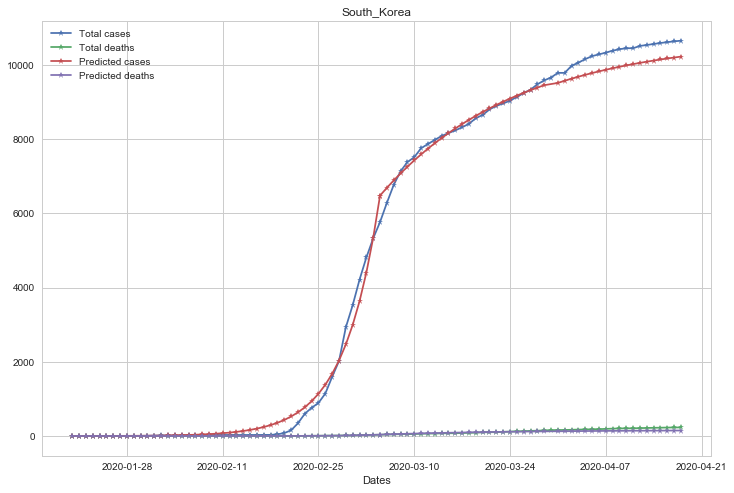

In [24]:
days_to_predict = 20 # Let's lower the number as this is more recent
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='South_Korea', measure_date='2020-03-06', 
                                                                N=51710000, days_to_predict = days_to_predict)
data = get_country(world_data, 'South_Korea')
plt.figure(figsize=(12,8))
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-(days_to_predict):]).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5])
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('South_Korea')
plt.xlabel('Dates');

In [25]:
error_value(np.cumsum(data[1]), pred_cases)

0.040487744994050216

This is a pretty good estimate for the last 20 days. Now let's return to our objective, what will happen in Germany, Italy, Spain and, finally, Turkey.

## Results

Let's see how SIRD model fits the data for Turkey and Germany.

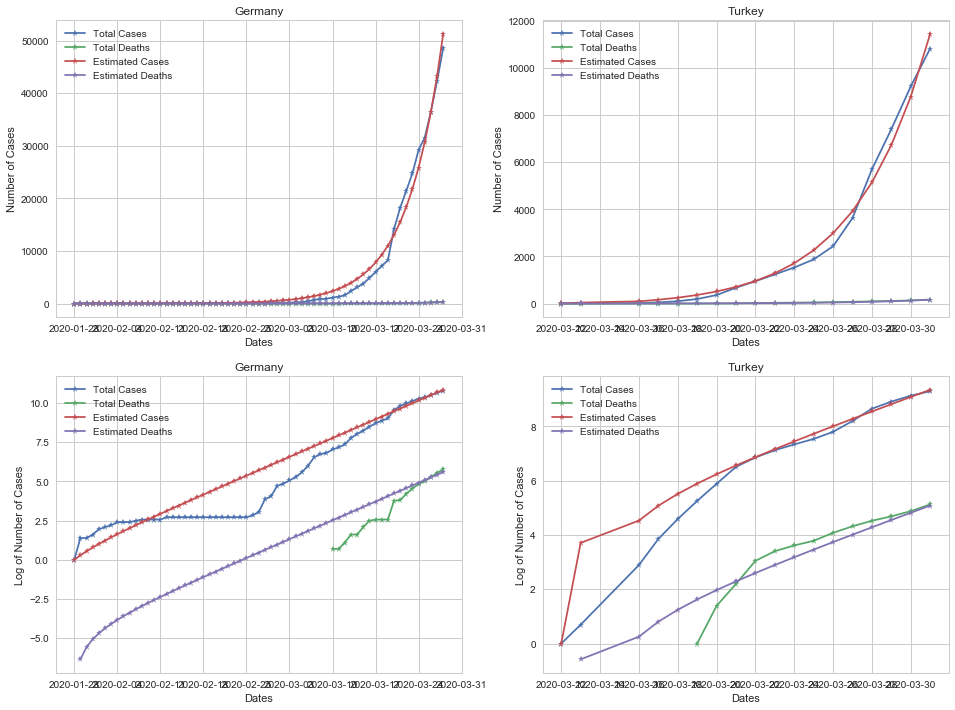

In [26]:
plt.subplots(2,2, figsize=(16,12))
plt.subplot(2,2,1)
plt.plot_date(dates_g, cases_g, '-*', label= 'Total Cases')
plt.plot_date(dates_g, deaths_g, '-*', label= 'Total Deaths')
plt.plot_date(dates_g, est_cases_g, '-*', label='Estimated Cases')
plt.plot_date(dates_g, est_deaths_g, '-*', label='Estimated Deaths')
plt.legend()
plt.title('Germany')
plt.xlabel('Dates')
plt.ylabel('Number of Cases')

plt.subplot(2,2,2)
plt.plot_date(dates_t, cases_t, '-*', label= 'Total Cases')
plt.plot_date(dates_t, deaths_t, '-*', label= 'Total Deaths')
plt.plot_date(dates_t, est_cases_t, '-*', label='Estimated Cases')
plt.plot_date(dates_t, est_deaths_t, '-*', label='Estimated Deaths')
plt.legend()
plt.title('Turkey')
plt.xlabel('Dates')
plt.ylabel('Number of Cases');

plt.subplot(2,2,3)
plt.plot_date(dates_g, np.log(cases_g), '-*', label= 'Total Cases')
plt.plot_date(dates_g, np.log(deaths_g), '-*', label= 'Total Deaths')
plt.plot_date(dates_g, np.log(est_cases_g), '-*', label='Estimated Cases')
plt.plot_date(dates_g, np.log(est_deaths_g), '-*', label='Estimated Deaths')
plt.legend()
plt.title('Germany')
plt.xlabel('Dates')
plt.ylabel('Log of Number of Cases')

plt.subplot(2,2,4)
plt.plot_date(dates_t, np.log(cases_t), '-*', label= 'Total Cases')
plt.plot_date(dates_t, np.log(deaths_t), '-*', label= 'Total Deaths')
plt.plot_date(dates_t, np.log(est_cases_t), '-*', label='Estimated Cases')
plt.plot_date(dates_t, np.log(est_deaths_t), '-*', label='Estimated Deaths')
plt.legend()
plt.title('Turkey')
plt.xlabel('Dates')
plt.ylabel('Log of Number of Cases');

The errors are not similar even though the graphs for total cases are similar for these countries. One possible explanation is that the number of cases increase very quickly after the first case in Turkey. This is due to excessive contact tracing. A clearer contrast can be seen in the figures with logarithmic scale. The number of cases stay frozen in Germany for a while which is unlikely considering how fast the pandemic spreads. Turkey, with the advantage of a late start, was more prepared and people were more alert.

Now, let us see if we the model is useful when there are not many measures, i.e. early stages. In Germany, the social distancing measures took effect starting March 13 with closure of schools, etc. One day later, borders were closed and a week later curfew was imposed. There is no curfew for Turkey but the social distancing measures took effect aat March 16th.

Now, let us try to predict the future values for several countries.

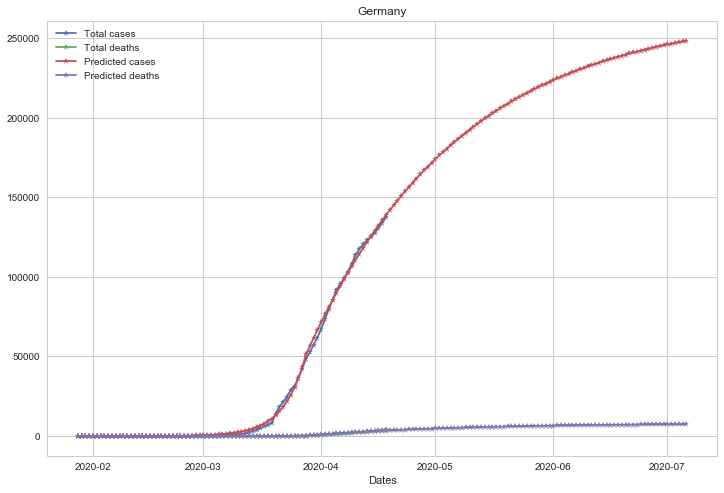

In [27]:
days_to_predict = 0 # Let's use all we have.
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Germany', measure_date='2020-03-29', 
                                                                N=84*10**6, days_to_predict = days_to_predict)
data = get_country(world_data, 'Germany')
plt.figure(figsize=(12,8))
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

days_to_predict = 80 # This is to estimate future.
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-1]+np.arange(days_to_predict)).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5])
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('Germany')
plt.xlabel('Dates');

In [28]:
print(popt)
error_value(cases, est_cases)

[0.30334233 0.13051881 0.0015962  0.18472814 0.20245199 0.00675232]


0.03047678767098857

We can state that although case number is projected to increase, deaths do not increase that much. Also it looks like we are probably still at an early phase to model the second part. Still, what we see after the measures is not similar to China, so there might be a need for more precautions. The model looks matching to the current cases but a chnage in societal dynamics, as shown in earlier examples is highly affecting the parameters. 

Now, let's see Italy.

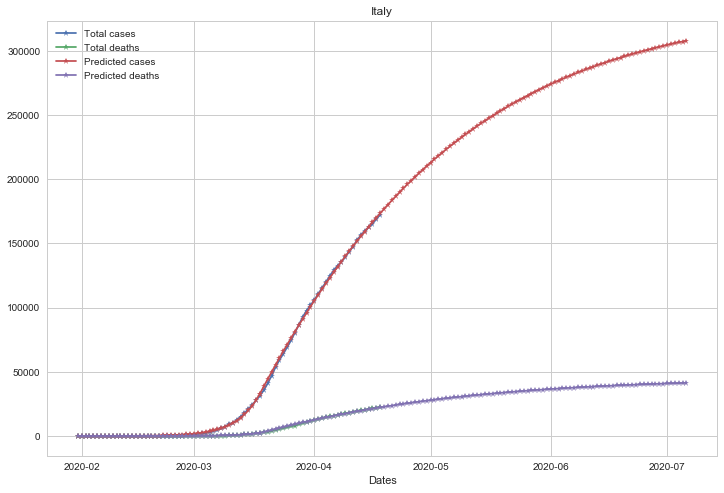

In [29]:
days_to_predict = 0 # Let's use all we have.
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Italy', measure_date='2020-03-19', 
                                                                N=60*10**6, days_to_predict = days_to_predict)
data = get_country(world_data, 'Italy')
plt.figure(figsize=(12,8))
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

days_to_predict = 80 # This is to estimate future.
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-1]+np.arange(days_to_predict)).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5])
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('Italy')
plt.xlabel('Dates');

In [30]:
print(popt)
error_value(cases, est_cases)

[1.96949976 1.65711803 0.143077   2.01280662 1.74064573 0.28486868]


0.013417838126834182

That's a bleak picture, which is hopefully wrong. We know that number of new cases is dropping but if the model is correct, we will see 250 thousands. We also need to keep in mind that the model thinks the whole population of Italy is connected, although we know right now that the regions are separated with travel restrictions. This might have an impact on the model as the population is a big factor.

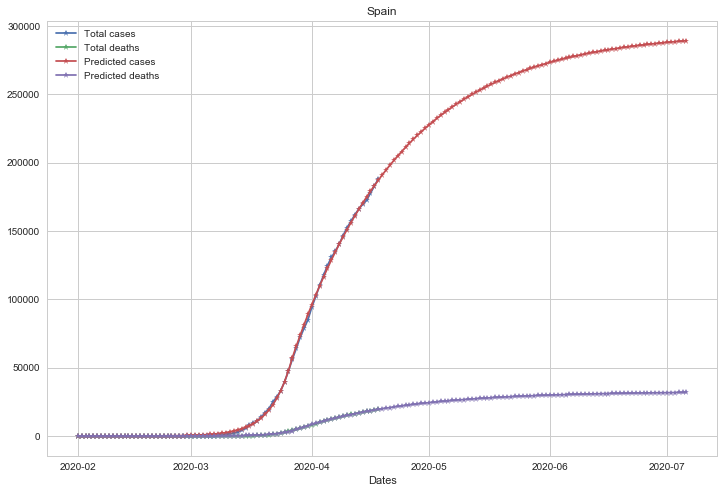

In [31]:
days_to_predict = 0 # Let's use all we have.
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Spain', measure_date='2020-03-28', 
                                                                N=47*10**6, days_to_predict = days_to_predict)
data = get_country(world_data, 'Spain')
plt.figure(figsize=(12,8))
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

days_to_predict = 80 # This is to estimate future.
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-1]+np.arange(days_to_predict)).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5])
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('Spain')
plt.xlabel('Dates');

In [32]:
print(popt)
error_value(cases, est_cases)

[0.43270484 0.22046514 0.02855114 0.34805433 0.34014408 0.04205364]


0.013733665097188597

Another scary picture. Although the number of deaths do not increase, the model shows that the cases will keep increasing.

Now let's look at Turkey. But before that, let's choose the day with some quantitative selection. We will check 5 different days of inflection and take the best fit for current data.

In [33]:
days_to_predict = 0 # Let's use all we have.
error_list = []
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', measure_date='2020-03-24', 
                                                                N=84*10**6, days_to_predict = days_to_predict)
days_to_predict = 0 # Let's use all we have.
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', measure_date='2020-03-26', 
                                                                N=84*10**6, days_to_predict = days_to_predict)
days_to_predict = 0 # Let's use all we have.
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', measure_date='2020-03-28', 
                                                                N=84*10**6, days_to_predict = days_to_predict)
days_to_predict = 0 # Let's use all we have.
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', measure_date='2020-03-30', 
                                                                N=84*10**6, days_to_predict = days_to_predict)
days_to_predict = 0 # Let's use all we have.
error_list.append(error_value(cases, est_cases))
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', measure_date='2020-04-01', 
                                                                N=84*10**6, days_to_predict = days_to_predict)
error_list.append(error_value(cases, est_cases))
error_list

[0.041304332087760916,
 0.02267094444441011,
 0.01956404178706028,
 0.024059701649302222,
 0.022048107082470073]

Looks like March 28th gives the best fit. Let's see the predictions now. 

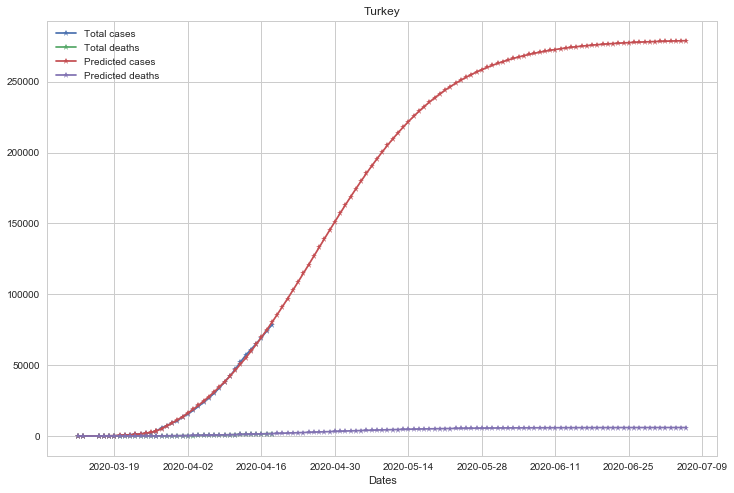

In [34]:
days_to_predict = 0 # Let's use all we have.
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='Turkey', measure_date='2020-03-28', 
                                                                N=84*10**6, days_to_predict = days_to_predict)
data = get_country(world_data, 'Turkey')
plt.figure(figsize=(12,8))
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

days_to_predict = 80 # This is to estimate future.
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-1]+np.arange(days_to_predict)).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5])
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('Turkey')
plt.xlabel('Dates');

In [35]:
print(popt)
error_value(cases, est_cases)

[26.70982795 25.83049435  0.59991655 45.77941644 44.72374519  0.98463048]


0.01956404178706028

It looks like it's not going to end pretty soon. Hopefully the model is overestimating, just like the case with China. Also, the government seems to be imposing more restrictions now, so let's hope some parameters change and it gets better. 

Now, a bonus analysis. Hopefully a happy one.

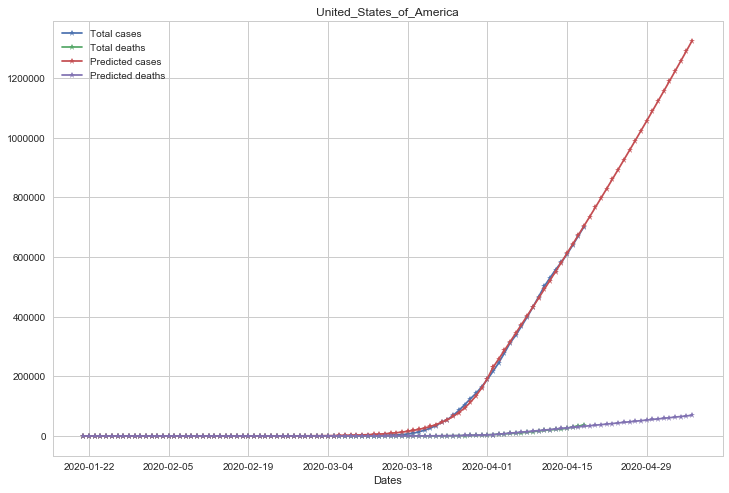

In [36]:
days_to_predict = 0 # Let's use all we have.
dates, cases, deaths, est_cases, est_deaths, popt = fit_country(world_data, country='United_States_of_America', 
                                                                measure_date='2020-04-03', 
                                                                N=331*10**6, days_to_predict = days_to_predict)
data = get_country(world_data, 'United_States_of_America')
plt.figure(figsize=(12,8))
plt.plot_date(data[0], np.cumsum(data[1]), '-*', label='Total cases')
plt.plot_date(data[0], np.cumsum(data[2]), '-*', label='Total deaths')

days_to_predict = 20 # This is to estimate future.
t = np.arange(len(second_out[0]))
soln = odeint(f, y0, t, args=tuple(second_out[-1]))
y0 = soln[-1,:]
t = np.hstack(data[0].iloc[-1]+np.arange(days_to_predict)).astype(np.float)
time = np.concatenate((dates, t[1:]))
est = sird_odeint(t, popt[3], popt[4], popt[5])
pred_cases, pred_deaths = np.split(est, 2)
pred_cases = np.concatenate((est_cases, pred_cases[1:]))
pred_deaths = np.concatenate((est_deaths, pred_deaths[1:]))
plt.plot_date(time, pred_cases, '-*', label='Predicted cases')
plt.plot_date(time, pred_deaths, '-*', label='Predicted deaths')
plt.legend()
plt.title('United_States_of_America')
plt.xlabel('Dates');

In [37]:
print(popt)
error_value(cases, est_cases)

[ 0.10484474 -0.07614432  0.00209177  0.07227025  0.06218394  0.0042706 ]


0.02183081338775576

I am not going to 80 days. With this many cases it is not very reasonable. Let's hope that the model is overestimating.  

## Discussion

- In this report we analyzed the COVID-19 Data for case and death count prediction using SIRD model. 
- As the model does not take the parameter changes into account, for an ongoing pandemic it is hard to estimate the best values. 
- Yet, making an assumption in regards to the stages of the pandemic, we were able to create a model that can fit and predict better than the original model. 
- Using the model parameters some predictions were made.
- **The predictions have no implications as the author is not an expert in the subject.**
- It can be seen that the model tends to overestimate and is not taking many underlying information into account, still some predictions can easily made regarding the implications of an early lockdown or public awareness. 



## Conclusions

1. Earlier lockdowns, or other measures effect the number of infected greatly, reducing also the death toll. 
2. The two stage model approach can be extended to three or higher stages as sometimes countries take extra measures after a new discovery.
3. The model might be improved using number of tests, recoveries and other data into account. This might provide better and more trustworthy predictions.
4. The model also can be improved to focus on states, cities and counties and their relationship to better explain the underlying dynamics such as connectivity and population density.

### References

[1] “Download Today's Data on the Geographic Distribution of COVID-19 Cases Worldwide.” European Centre for Disease Prevention and Control, 18 Apr. 2020, www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide.

[2] “Compartmental Models in Epidemiology.” Wikipedia, Wikimedia Foundation, 15 Apr. 2020, en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model.